In [1]:
from model import *
from utils import * 
from optimizer import *
from visualize import *
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Initialize dataset

In [2]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [3]:
max_n_nodes = get_max_n_nodes(dataset)
print(f'Max number of nodes: {max_n_nodes}')

Max number of nodes: 28


In [4]:
dataset = update_dataset(dataset, max_n_nodes)

In [5]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

## Initialize & train a model

In [29]:
n_nodes = 28
feat_dim = 7
hidden1 = 32
hidden2 = 2
dropout = 0.0
lr = 1e-4
epochs = 150
log_interval = 25
save_file = 'model'

In [30]:
model = GCNModelVAE(n_nodes, feat_dim, hidden1, hidden2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
log = fit(model, optimizer, train_loader, test_loader, epochs, save_file)

Training for 150 epochs: 100%|████████████████| 150/150 [00:17<00:00,  8.44it/s]

Optimization Finished!
Best epoch: 48 , Best test set loss: 71.1263


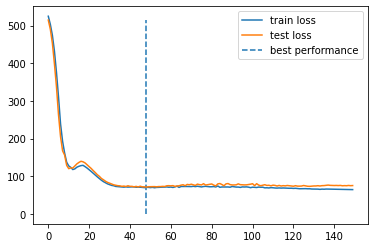

In [32]:
performance_plot(log)

## Visualize results

In [33]:
model.state_dict = torch.load('model')

In [34]:
# get random graph as Data object
data = random.choice(list(train_loader))
# the Data object is a batch => take a random index from the batch
n = random.choice(range(len(data.y)))

recovered, mu, logvar = model(data.x, data.edge_index, data.batch)
adj = data.adj
mask = create_mask(n_nodes)

In [35]:
recovered = (recovered.view(-1, n_nodes, n_nodes)*mask).detach().numpy()[n]
adj = (adj.view(-1, n_nodes, n_nodes)*mask).detach().numpy()[n]

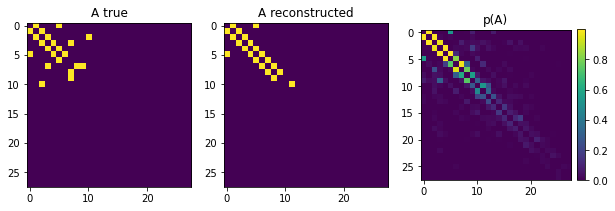

In [36]:
visualize_recon_adj(recovered, adj)

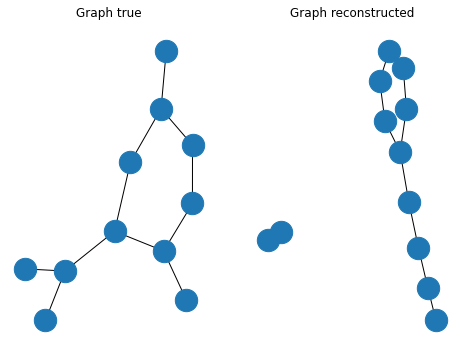

In [37]:
visualize_recon_graph(recovered, adj)

## Latent space (2D case)

In [38]:
model.state_dict = torch.load('model')

In [39]:
assert model.latent_dim == 2

In [40]:
all_loader = DataLoader(dataset, batch_size=10**10, shuffle=True)

In [41]:
data = next(iter(all_loader))

In [42]:
mu, logvar = model.encode(data.x, data.edge_index, data.batch)
z = model.reparameterize(mu, logvar).detach().numpy()

No handles with labels found to put in legend.


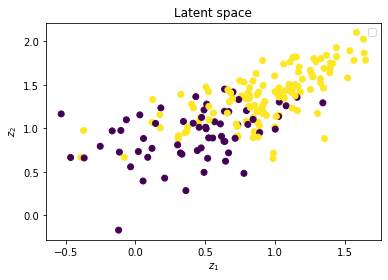

In [43]:
visualize_z_space(z, data.y)

## Inference task I: $argmax_{A}p(A|y)$ 

In [44]:
y = 1

In [45]:
mask = create_mask(n_nodes)

In [46]:
z_y = get_cluster(model, dataset, y)
z_centre = cluster_centre(z_y)

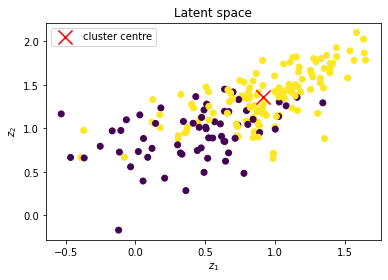

In [47]:
visualize_z_space(z, data.y, z_centre.detach().numpy())

In [48]:
a_y = model.decode(z_centre).view(model.n_nodes,model.n_nodes)
a_y = (a_y*mask).detach().numpy().squeeze()

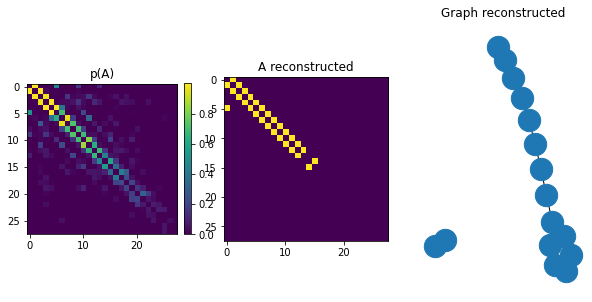

In [49]:
visualize_adj_graph(a_y)

## Inference task II: $argmax_{z_i \in Z} MI(z_i, Y)$ 

In [28]:
# TODO